<div class="alert alert-block alert-info" style="text-align:center;">
   <h1 style="font-size: 24px;">Project 1 - Dairy Cow Teat Classification using Neural Network</h1>
</div>

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier # using 1NN
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm 
from torchvision.utils import make_grid
from torchvision.utils import save_image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [52]:
import torch
torch.cuda.empty_cache()

# Download the [cow teat datasets](https://github.com/YoushanZhang/SCTL)  resize image to (224, 224)

### (1). Create a train data loader that returns image arrays and labels

In [53]:
def train_data_loader(train_dirs, image_size=(224, 224)):
    # Initialize empty lists to store image arrays and labels
    image_arrays = []
    image_labels = []
   
    # Define image transformation parameters
    image_transform = cv2.getRotationMatrix2D((image_size[0] / 2, image_size[1] / 2), 30, 1.0)
    
    # Loop to navigate all directories and read information from all the image files
    for label, directory in enumerate(sorted(os.listdir(train_dirs))):
        path = os.path.join(train_dirs, directory)

        # Check if it's a directory
        if not os.path.isdir(path):
            continue

        # Iterate over image files in the directory
        for img_file in os.listdir(path):
            img_path = os.path.join(path, img_file)

            # Read and transform images
            img = plt.imread(img_path).copy()
            img = cv2.resize(img, image_size)
            
            # Apply additional image transformations (e.g., rotation)
            img = cv2.warpAffine(img, image_transform, image_size)
            
            # Normalize image values to the range [0, 1]
            img = img.astype(np.float32) / 255.0
            
            image_labels.append(label)
            image_arrays.append(img)
            
    return image_arrays, image_labels

### (2). Create a test data loader that returns image arrays and file names

In [54]:
def test_data_loader(data_dir, image_size=(224, 224)):
    # Get a list of image files in the test data directory
    image_files = [f for f in os.listdir(data_dir) if f.endswith(".jpg")]
    
    # Initialize lists for data and file names
    image_arrays = []
    image_names = []
    
    # Define image transformation parameters
    image_transform = cv2.getRotationMatrix2D((image_size[0] / 2, image_size[1] / 2), 30, 1.0)
    
    # Iterate over the image files
    for file in image_files:
        # Get the full path of the image
        path = os.path.join(data_dir, file)
        
        # Read and transform the image
        img = plt.imread(path).copy()
        img = cv2.resize(img, image_size)
        
        # Apply additional image transformations (e.g., rotation)
        img = cv2.warpAffine(img, image_transform, image_size)
        
        # Normalize image values to the range [0, 1]
        img = img.astype(np.float32) / 255.0
        
        # Append the preprocessed image and file name to the lists
        image_arrays.append(img)
        image_names.append(file)
    
    # Convert lists to NumPy arrays and return
    return image_arrays, image_names

### (3). Print image arrays, labels and file names dimensions 

### Training Dataset

In [55]:
train_loader = r'C:\AKA\Backup Dell Laptop\D Drive\YU\Semester 2\Neural Network\DLNN\Assignment_Week5\Homework Week5\Homework Week5\Training'
training_array, training_labels = train_data_loader(train_loader)
training_array, training_labels = np.array(training_array), np.array(training_labels)

print("Training Dataset Array:",training_array.shape )
print("Training Label Shape:",training_labels.shape )

Training Dataset Array: (1149, 224, 224, 3)
Training Label Shape: (1149,)


**Observation:**
   - The training dataset contains total 1149 images of size 224, 224 and has 3 channels.

### Test Dataset

In [56]:
# Example usage
test_loader=r'C:\AKA\Backup Dell Laptop\D Drive\YU\Semester 2\Neural Network\DLNN\Assignment_Week5\Homework Week5\Homework Week5\Test_Data'
test_array, test_file_name = test_data_loader(test_loader)
test_array, test_file_name = np.array(test_array), np.array(test_file_name)

print("Test Dataset Array:",test_array.shape )
print("Test File Names Extracted:",test_file_name.shape )

Test Dataset Array: (380, 224, 224, 3)
Test File Names Extracted: (380,)


**Observation:**
   - The test dataset contains total 380 images of size 224, 224 and has 3 channels.

In [57]:
# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(training_array, training_labels, test_size=0.2, random_state=42)

print("Training Dataset Array:", X_train.shape)
print("Validation Dataset Array:", X_val.shape)

Training Dataset Array: (919, 224, 224, 3)
Validation Dataset Array: (230, 224, 224, 3)


## Build your own convolutional neural network using pytorch

In [59]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out += self.shortcut(x)  
        out = self.relu2(out)
        return out

class ImprovedNeuralNetwork(nn.Module):
    def __init__(self):
        super(ImprovedNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 256, kernel_size=3, stride=1, padding=1)
        #self.bn1 = nn.BatchNorm2d(256)  
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.residual_block1 = ResidualBlock(256, 256)
        #self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.residual_block2 = ResidualBlock(256, 128)
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.residual_block3 = ResidualBlock(128, 64)
        self.pool7 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.residual_block4 = ResidualBlock(64, 64)
#         self.pool10 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.residual_block5 = ResidualBlock(64, 32)
#         self.pool11 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.residual_block6 = ResidualBlock(32, 32)
#         self.pool12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(12544, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc5 = nn.Linear(128, 128)
        self.relu8 = nn.ReLU()
        self.fc6 = nn.Linear(128, 64)
        self.relu9 = nn.ReLU()
        self.fc3 = nn.Linear(64, 4)  

    def forward(self, x):
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.residual_block1(x)
        #x = self.bn2(x) 
        x = self.pool2(x)
        x = self.residual_block2(x)
        x = self.pool6(x)
        x = self.residual_block3(x)
        x = self.pool7(x)
#         x = self.residual_block4(x)
#         x = self.pool10(x)
#         x = self.residual_block5(x)
#         x = self.pool11(x)
#         x = self.residual_block6(x)
#         x = self.pool12(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc5(x)
        x = self.relu8(x)
        x = self.fc6(x)
        x = self.relu9(x)
        x = self.fc3(x)
        return x


In [60]:
# Initialize your neural network (no arguments needed)
model = ImprovedNeuralNetwork()

# Define the optimizer (e.g., Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [61]:
# Convert data to PyTorch tensors
training_data = torch.Tensor(X_train)
training_labels = torch.LongTensor(y_train)
validation_data = torch.Tensor(X_val)
validation_labels = torch.LongTensor(y_val)

# permute the dimensions to match the expected shape [num_samples, 3, 224, 224]
training_data = training_data.permute(0, 3, 1, 2)
validation_data = validation_data.permute(0, 3, 1, 2)

## Train your model using cow teat datasets (you may need to use Google Colab (or Kaggle) with GPU to train your code)

In [62]:
# Set the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda:0


In [63]:
# Create TensorDatasets for training and validation
training_dataset = TensorDataset(training_data, training_labels)
validation_dataset = TensorDataset(validation_data, validation_labels)

In [64]:
# Create DataLoaders with batch sizes
batch_size = 8 
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Training loop
num_epochs = 20  

# Lists to store training and validation metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    with tqdm(train_loader, unit="batch") as t:
        for data, labels in t:
            optimizer.zero_grad()
            outputs = model(data.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.to(device)).sum().item()
            accuracy = 100.0 * correct / total
            t.set_postfix(loss=total_loss / (t.n + 1), accuracy=accuracy)  # Update the progress bar
    
    # Calculate training accuracy and loss for this epoch
    train_loss = total_loss / len(train_loader)
    train_acc = accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation loop
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with tqdm(valid_loader, unit="batch") as t:
        for data, labels in t:
            outputs = model(data.to(device))
            loss = criterion(outputs, labels.to(device))
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.to(device)).sum().item()
            accuracy = 100.0 * correct / total
            t.set_postfix(loss=total_loss / (t.n + 1), accuracy=accuracy)  

    # Calculate validation accuracy and loss for this epoch
    valid_loss = total_loss / len(valid_loader)
    valid_acc = accuracy
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%')
    print(f'Validation - Epoch [{epoch+1}/{num_epochs}], Loss: {valid_loss:.4f}, Accuracy: {valid_acc:.2f}%')

100%|████████████████████████████████████████████████████| 29/29 [00:07<00:00,  4.00batch/s, accuracy=62.6, loss=0.993]


Training - Epoch [1/20], Loss: 1.1165, Accuracy: 46.46%
Validation - Epoch [1/20], Loss: 0.9588, Accuracy: 62.61%


100%|█████████████████████████████████████████████████████| 29/29 [00:07<00:00,  4.04batch/s, accuracy=63.9, loss=1.05]


Training - Epoch [2/20], Loss: 0.9817, Accuracy: 58.32%
Validation - Epoch [2/20], Loss: 1.0180, Accuracy: 63.91%


100%|████████████████████████████████████████████████████| 29/29 [00:07<00:00,  4.07batch/s, accuracy=64.8, loss=0.988]


Training - Epoch [3/20], Loss: 0.9682, Accuracy: 57.89%
Validation - Epoch [3/20], Loss: 0.9539, Accuracy: 64.78%


100%|████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.99batch/s, accuracy=63.9, loss=0.981]


Training - Epoch [4/20], Loss: 0.9433, Accuracy: 60.61%
Validation - Epoch [4/20], Loss: 0.9476, Accuracy: 63.91%


100%|█████████████████████████████████████████████████████| 29/29 [00:07<00:00,  4.08batch/s, accuracy=64.3, loss=0.99]


Training - Epoch [5/20], Loss: 0.9255, Accuracy: 61.26%
Validation - Epoch [5/20], Loss: 0.9559, Accuracy: 64.35%


100%|████████████████████████████████████████████████████| 29/29 [00:07<00:00,  4.08batch/s, accuracy=65.2, loss=0.952]


Training - Epoch [6/20], Loss: 0.9146, Accuracy: 61.15%
Validation - Epoch [6/20], Loss: 0.9191, Accuracy: 65.22%


100%|█████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.73batch/s, accuracy=58.7, loss=1.07]


Training - Epoch [7/20], Loss: 0.9059, Accuracy: 61.92%
Validation - Epoch [7/20], Loss: 1.0351, Accuracy: 58.70%


100%|████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.74batch/s, accuracy=63.5, loss=0.989]


Training - Epoch [8/20], Loss: 0.9609, Accuracy: 61.15%
Validation - Epoch [8/20], Loss: 0.9548, Accuracy: 63.48%


100%|████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.70batch/s, accuracy=62.2, loss=0.978]


Training - Epoch [9/20], Loss: 0.9096, Accuracy: 62.24%
Validation - Epoch [9/20], Loss: 0.9438, Accuracy: 62.17%


100%|█████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.65batch/s, accuracy=65.7, loss=1.01]


Training - Epoch [10/20], Loss: 0.9106, Accuracy: 61.15%
Validation - Epoch [10/20], Loss: 1.0143, Accuracy: 65.65%


100%|██████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.63batch/s, accuracy=60, loss=0.991]


Training - Epoch [11/20], Loss: 0.8964, Accuracy: 60.83%
Validation - Epoch [11/20], Loss: 0.9571, Accuracy: 60.00%


100%|████████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.73batch/s, accuracy=66.1, loss=1]


Training - Epoch [12/20], Loss: 0.8733, Accuracy: 61.59%
Validation - Epoch [12/20], Loss: 0.9662, Accuracy: 66.09%


100%|████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.63batch/s, accuracy=64.3, loss=0.963]


Training - Epoch [13/20], Loss: 0.8661, Accuracy: 62.79%
Validation - Epoch [13/20], Loss: 0.9632, Accuracy: 64.35%


100%|████████████████████████████████████████████████████| 29/29 [00:08<00:00,  3.62batch/s, accuracy=64.8, loss=0.953]


Training - Epoch [14/20], Loss: 0.8477, Accuracy: 62.68%
Validation - Epoch [14/20], Loss: 0.9532, Accuracy: 64.78%


100%|████████████████████████████████████████████████████| 29/29 [00:08<00:00,  3.58batch/s, accuracy=64.3, loss=0.954]


Training - Epoch [15/20], Loss: 0.8488, Accuracy: 61.48%
Validation - Epoch [15/20], Loss: 0.9538, Accuracy: 64.35%


100%|██████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.66batch/s, accuracy=63, loss=0.994]


Training - Epoch [16/20], Loss: 0.8251, Accuracy: 62.35%
Validation - Epoch [16/20], Loss: 0.9599, Accuracy: 63.04%


100%|██████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.67batch/s, accuracy=63, loss=0.967]


Training - Epoch [17/20], Loss: 0.8073, Accuracy: 65.07%
Validation - Epoch [17/20], Loss: 0.9668, Accuracy: 63.04%


100%|█████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.70batch/s, accuracy=49.1, loss=1.07]


Training - Epoch [18/20], Loss: 0.7968, Accuracy: 62.89%
Validation - Epoch [18/20], Loss: 1.0296, Accuracy: 49.13%


100%|████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.67batch/s, accuracy=62.6, loss=0.967]


Training - Epoch [19/20], Loss: 0.7772, Accuracy: 63.00%
Validation - Epoch [19/20], Loss: 0.9675, Accuracy: 62.61%


100%|█████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.73batch/s, accuracy=59.6, loss=1.06]

Training - Epoch [20/20], Loss: 0.7464, Accuracy: 65.51%
Validation - Epoch [20/20], Loss: 1.0221, Accuracy: 59.57%


In [65]:
# Save the trained model
torch.save(model.state_dict(), 'trained_model_3010_3.pth')

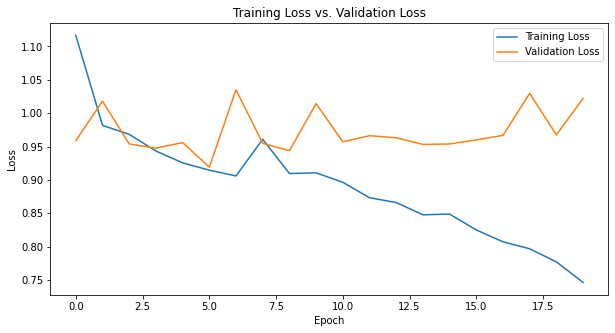

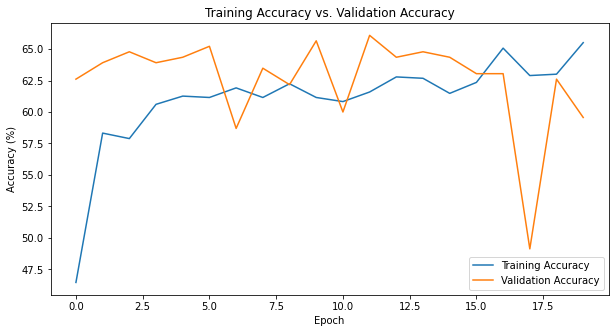

In [66]:
# Plot Training Loss vs. Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss vs. Validation Loss')
plt.show()

# Plot Training Accuracy vs. Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training Accuracy vs. Validation Accuracy')
plt.show()

In [67]:
from torchsummary import summary

# Provide the input shape as a tuple (channels, height, width)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 224, 224]           7,168
              ReLU-2        [-1, 256, 224, 224]               0
         MaxPool2d-3        [-1, 256, 112, 112]               0
            Conv2d-4        [-1, 256, 112, 112]         590,080
              ReLU-5        [-1, 256, 112, 112]               0
            Conv2d-6        [-1, 256, 112, 112]         590,080
              ReLU-7        [-1, 256, 112, 112]               0
     ResidualBlock-8        [-1, 256, 112, 112]               0
         MaxPool2d-9          [-1, 256, 56, 56]               0
           Conv2d-10          [-1, 128, 56, 56]         295,040
             ReLU-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 128, 56, 56]         147,584
           Conv2d-13          [-1, 128, 56, 56]          32,896
             ReLU-14          [-1, 128,

In [68]:


# Define your neural network class

# Define your data loading functions

# Load your trained model
model = ImprovedNeuralNetwork()
model.load_state_dict(torch.load('trained_model_3010_3.pth'))
model.eval()  # Set the model to evaluation mode

# Assuming 'test_array' has shape [num_samples, 224, 224, 3]
test_data = torch.Tensor(test_array).permute(0, 3, 1, 2)

# Make predictions on the test data
with torch.no_grad():
    test_outputs = model(test_data)

# Get the predicted labels (assuming you are using softmax as the final layer)
_, predicted_labels = torch.max(test_outputs, 1)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'test_file_names': test_file_name,
    'predicted_labels': predicted_labels
})

# Save the results to a CSV file
results_df.to_csv(r'C:\Users\ankit\OneDrive\Desktop\prediction_result_2910.csv', index=False, header=False)

print("Results saved to prediction_result_2910.csv")

Results saved to prediction_result_2910.csv


## Evaluate your model using the developed software 

## Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%


## Achieved result is a bit lesser than VGG16 Accuracy by 2.86%



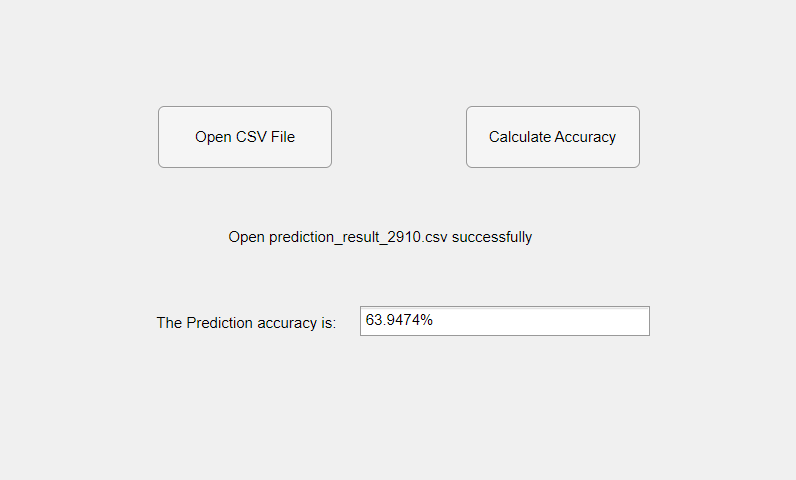

## Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

1. Research Paper: https://www.researchgate.net/publication/375491199_Dairy_Cow_Teat_Health_Condition_Classification_using_Deep_Learning_Techniques

2. GitHub Weight Link: https://github.com/ankitagg2008/Image-Classification---Dairy-Cow-Teat-Health-Conditon/blob/94d61c5ca67376c41dba1e3b6a47893b7349ac29/trained_model_3010_3.pth

## Citations: 

1. Youshan Zhang, Ian R Porter, Matthias Wieland, and Parminder S Basran. Separable confident transductive learning for dairy cows teat-end condition classification. Animals, 12(7):886, 2022.
2. Youshan Zhang's Git Repository: https://github.com/YoushanZhang/SCTL
3. https://en.wikipedia.org/wiki/Residual_neural_network
4. https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
5. https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/
6. https://towardsdatascience.com/building-a-residual-network-with-pytorch-df2f6937053b